# Survival analysis 

In [155]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

In [156]:
file_name = "M-3-[None-None]-[AGE]-lcm.out"

In [319]:
def read_group(file_name , groups_folder= "../plots/groups/"):
    groups = pd.read_csv(f"{groups_folder}{file_name}",index_col=0)
    groups.drop(["size","depth"],axis=1,inplace=True)
    groups["itemsets"] = groups["itemsets"].apply(lambda x : [int(i) for i in x.split()])
    groups["user_ids"] = groups["user_ids"].apply(lambda x : [int(i) for i in x[1:-1].split(",")])
    return groups

def splited_links(file_name):
    links = pd.read_csv(f"../plots/links/{file_name}")
    res = []
    links.apply(lambda x : [res.append((x["source"],x["target"], int(i) )) for i in x["user_id"].split(",")] ,axis=1)
    return  pd.DataFrame(res,columns=["source","target","user_id"])

def count_consecutives(x):
    return x.groupby((x!=x.shift()).cumsum()).transform("size")

In [320]:
groups = read_group(file_name)
groups.head()

,user_ids,support,itemsets,period,property_values,AGE,itemset_name
0,"[100842, 102647, 102939, 105649, 107874, 10796...",669,[],2017-03-01,35-49,35-49,[]
1,"[120248, 121128, 129748, 164308, 344630]",5,[4132],2017-03-01,50-65,50-65,['LAVAGE 3 PLEIN']
2,"[124990, 140591, 233959, 241319, 266265, 27876...",7,[6723],2017-03-01,50-65,50-65,['SAN PELLEGRINO 50CL']
3,"[187833, 198513, 518210, 576233]",4,[721],2017-03-01,50-65,50-65,['BD. PAIN CHOCOLAT PAC']
4,"[187833, 518210, 576233]",3,"[721, 1622]",2017-03-01,50-65,50-65,"['BD. PAIN CHOCOLAT PAC', 'CR PAIN AU CHOCOLAT']"


In [160]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
mlb = MultiLabelBinarizer()
mlb.fit(groups.itemsets)

MultiLabelBinarizer(classes=None, sparse_output=False)

### Death : Pertiod t where the product does not appear in all  the groups in t+1,t+2,...

In [166]:
df = pd.DataFrame(mlb.fit_transform(groups.itemsets),index=groups.period,columns=mlb.classes_).unstack().reset_index().drop_duplicates()
df.columns = ["ARTICLE_ID","period","event"]
df = df.groupby(["ARTICLE_ID","period"])["event"].apply(np.logical_or.reduce).apply(np.logical_not).apply(int).reset_index()
df = df[df.event==1].groupby("ARTICLE_ID")["period"].max().reset_index()
df["event"] = 1
df.columns = ["ARTICLE_ID","days","event"]
df.days = (pd.to_datetime(df.days)- pd.to_datetime(df.days). min())
df.days = df.days.apply(lambda x : x.days).sort_values()
df.head()

,ARTICLE_ID,days,event
0,1,975,1
1,2,1005,1
2,3,1005,1
3,6,1005,1
4,8,1005,1


In [164]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

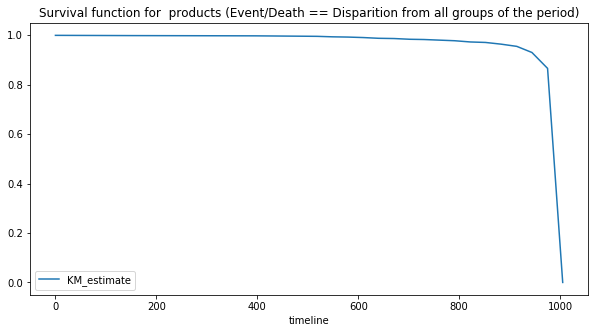

In [167]:
kmf.fit(df.days, event_observed=df.event)
kmf.survival_function_.plot(figsize=(10,5))
plt.title('Survival function for  products (Event/Death == Disparition from all groups of the period)');

###  Studiying the duration between consecutive appearances

In [321]:
df = pd.DataFrame(mlb.fit_transform(groups.itemsets),index=groups.period,columns=mlb.classes_).unstack().reset_index().drop_duplicates()
df.columns = ["ARTICLE_ID","period","event"]
# Article is either at 1 or 0 for every period
df = df.groupby(["ARTICLE_ID","period"])["event"].apply(np.logical_or.reduce).apply(int).reset_index()
# Count consecutive apparitions of same event 
df['consecutive'] =  df.groupby("ARTICLE_ID").event.apply(count_consecutives)
df = df[df.event != df.event.shift()]
# df.columns = ["ARTICLE_ID","days","event","consecutive"]
# df.days = (pd.to_datetime(df.days)- pd.to_datetime(df.days). min())
# df.days = df.days.apply(lambda x : x.days).sort_values()
df.head(20)

,ARTICLE_ID,period,event,consecutive
0,1,2017-03-01,0,1
1,1,2017-04-01,1,4
5,1,2017-08-01,0,1
6,1,2017-09-01,1,2
8,1,2017-11-01,0,2
10,1,2018-01-01,1,3
13,1,2018-04-01,0,1
14,1,2018-05-01,1,3
17,1,2018-08-01,0,2
19,1,2018-10-01,1,1


### Product consecutive disparition count 

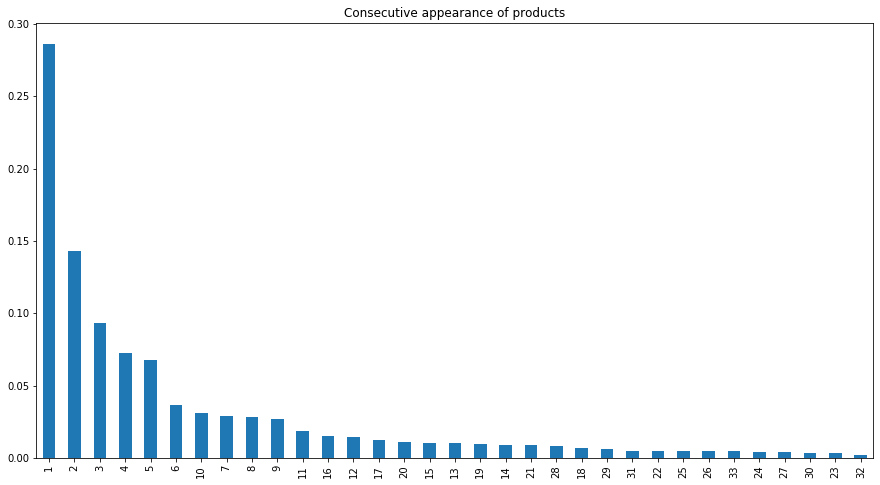

In [328]:
df[df.event==0].consecutive.value_counts(normalize=True).plot.bar(figsize=(15,8))
plt.title('Consecutive appearance of products');

### Consecutive appearances

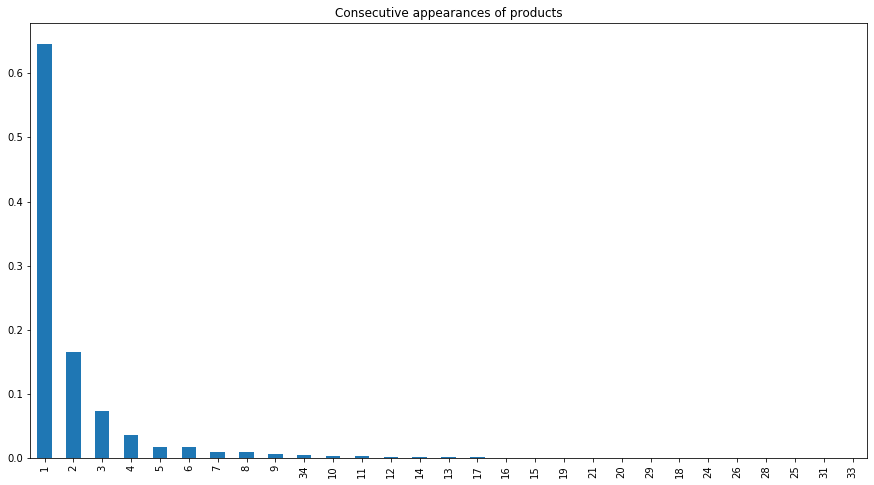

In [329]:
df[df.event==1].consecutive.value_counts(normalize=True).plot.bar(figsize=(15,8))
plt.title('Consecutive appearances of products');

In [333]:
groups[groups.itemsets.apply(lambda x : x in df[df.consecutive>30].ARTICLE_ID.unique())].itemset_name.unique()

/home/abdelouahab/3env/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array(["['SAN PELLEGRINO  50CL']", "['COCA COLA ZERO']",
       "['BD SDW LE LYONNAIS']", '["M&M\'S CACAHUETES 400G"]',
       "['RECHARGE LAVAGE TW - A']", '[]', "['BIDON AD BLUE 10L']",
       "['CAFE EXPRESSO']", "['SAC BOUTIQUE KRAFT']",
       "['CR FLAN NATURE']", "['LAVAGE 1 PLEIN']",
       "['RED BULL BTE 25CL']", "['BD CAFE CREME']",
       "['COCA COLA 50CL PET']", "['PRINGLES ORIGINAL 175G']",
       "['VITTEL BOUTEILL']", "['TW EFFACE RAYURES 100ML']",
       "['COCA COLA ZERO 50CL PET']", "['TOTAL ADBLUE BEC V. 5L']",
       "['PET 1,5L EAU MIN.']", "['TOTAL LAVE GLACE ETE 2L ECOLO']",
       "['EVIAN 50CL']", "['PRINGLES CREAM ONION 165G']",
       "['SDW XXL ROSETTE DE LYON CORNICHONS']", "['EVOLUTION FULL-']",
       "['POM POTE POIRE']", "['TROPICANA ORANGE SS PULPE 1L']",
       "['CRO SDW  PANINI 3 FROMAGGI']", "['BAGUETTE POULET CRUD 250G']",
       "['LAVE GLACE DEMO']", "['LAVAGE CLU']",
       "['CHAUSSON AUX POMMES NEUHAUSER']", "['MILKA DAIM 45G']",
       "['

In [103]:
groups.itemsets = groups.itemsets.apply(set)
links = splited_links(file_name)
links = links.merge(groups,left_on="source",right_index=True).merge(groups,left_on="target",right_index=True)
res = []


def run_query(x,res):
    user = x["user_id"]
    period = x["period_y"]
    for i in x["itemsets_x"].intersection(x["itemsets_y"]):
        res.append((period,i,1))
    for i in x["itemsets_x"].difference(x["itemsets_y"]):
        if (period,i,1) not in res:
            res.append((period,i,0))



links[:100].apply(lambda x:run_query(x,res),axis=1 )
df = pd.DataFrame(res,columns=["days","ARTICLE_ID","event"])
df.days = (pd.to_datetime(df.days)- pd.to_datetime(df.days). min())
df.days = df.days.apply(lambda x : x.days)
df.head()

,days,ARTICLE_ID,event
0,0,5827,0
1,0,4101,1
2,0,4101,1
3,0,4101,1
4,0,3510,0


Text(0.5, 1.0, 'Survival function for  products')

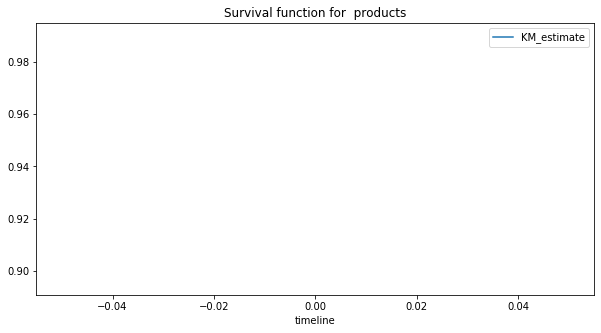

In [104]:
kmf.fit(df.days, event_observed=df.event)
kmf.survival_function_.plot(figsize=(10,5))
plt.title('Survival function for  products')

## Duration between two adoptions for a product

In [23]:
input_file = "M-3-[None-None]-[AGE]-lcm.out"
mlb = MultiLabelBinarizer()
groups = read_group(input_file)
mlb.fit(groups.itemsets)
res = []
groups.apply(lambda x :[res.append((x["period"],i,1)) for i in x["itemsets"]],axis=1)
df = pd.DataFrame(res,columns=["period","ARTICLE_ID","event"])
df = df[df.event==1]
df.groupby('ARTICLE_ID')["period"].apply(set).apply(len).to_frame().sort_values("period",ascending=False).to_csv("test.csv")

### Target products  : 
* 4074 : BIDON AD BLUE 10L
* 2946 : TW LAVE GLACE

In [37]:
groups=groups[groups.itemsets.apply(lambda x :  2946 in x or 4074 in x )]
res = []
groups.apply(lambda x : res.append((x["period"],x["AGE"])),axis=1)
groups

,user_ids,support,itemsets,period,property_values,AGE,itemset_name
42,"[104142, 107250, 113270, 137677, 167694, 16940...",24,[2946],2017-03-01,50-65,50-65,['TW LAVE GLACE']
43,"[100977, 104518, 113036, 121147, 168144, 16940...",19,[4074],2017-03-01,50-65,50-65,['BIDON AD BLUE 10L']
68,"[167077, 313520, 382915, 430029, 496995, 49861...",12,[2946],2017-03-01,<35,<35,['TW LAVE GLACE']
77,"[339292, 491709, 588938, 595924]",4,[4074],2017-03-01,<35,<35,['BIDON AD BLUE 10L']
159,"[160378, 195105, 199022, 223318, 247304, 26099...",25,[2946],2017-03-01,35-49,35-49,['TW LAVE GLACE']
...,...,...,...,...,...,...,...
15486,"[283278, 440924, 490190]",3,"[2946, 2975]",2019-12-01,35-49,35-49,"['TW LAVE GLACE', 'TW LAVE GLACE DEG. 4L']"
15487,"[304298, 371498, 493372, 756073, 1149491]",5,"[2946, 4112]",2019-12-01,35-49,35-49,"['LAVAGE CLU', 'TW LAVE GLACE']"
15488,"[490190, 493372, 539054, 911475]",4,"[2946, 4126]",2019-12-01,35-49,35-49,"['RECHARGE LAVAGE', 'TW LAVE GLACE']"
15489,"[112044, 126268, 179988, 183691, 252620, 28327...",36,[2946],2019-12-01,35-49,35-49,['TW LAVE GLACE']


In [27]:
groups[groups.apply(lambda x : 2946 in x["itemsets"],axis=1)]

,user_ids,support,itemsets,period,property_values,AGE,itemset_name
42,"[104142, 107250, 113270, 137677, 167694, 16940...",24,[2946],2017-03-01,50-65,50-65,['TW LAVE GLACE']
68,"[167077, 313520, 382915, 430029, 496995, 49861...",12,[2946],2017-03-01,<35,<35,['TW LAVE GLACE']
159,"[160378, 195105, 199022, 223318, 247304, 26099...",25,[2946],2017-03-01,35-49,35-49,['TW LAVE GLACE']
398,"[286476, 313520, 394148, 439245, 467240, 47387...",17,[2946],2017-04-01,<35,<35,['TW LAVE GLACE']
470,"[152806, 184838, 342376, 428148, 472871, 60462...",7,"[2946, 4126]",2017-04-01,35-49,35-49,"['RECHARGE LAVAGE', 'TW LAVE GLACE']"
...,...,...,...,...,...,...,...
15483,"[873816, 1149491, 1158650]",3,"[4136, 2946]",2019-12-01,35-49,35-49,"['RECHARGE LAVAGE TW - D', 'TW LAVE GLACE']"
15486,"[283278, 440924, 490190]",3,"[2946, 2975]",2019-12-01,35-49,35-49,"['TW LAVE GLACE', 'TW LAVE GLACE DEG. 4L']"
15487,"[304298, 371498, 493372, 756073, 1149491]",5,"[2946, 4112]",2019-12-01,35-49,35-49,"['LAVAGE CLU', 'TW LAVE GLACE']"
15488,"[490190, 493372, 539054, 911475]",4,"[2946, 4126]",2019-12-01,35-49,35-49,"['RECHARGE LAVAGE', 'TW LAVE GLACE']"


In [154]:
def encode(x):
    try:
        encoder.inverse_transform([x])
        return  "ABDOU"
    except: 
        return x
a =items.ARTICLE_ID.apply(encode)

In [155]:
for i in a:
    print(i)

3019081236250
5601045000427
3464381000276
3760049790801
3700232615702
3158849237938
3285053526685
3284090006136
3439496603995
3700311866087
8000864047915
3383390011236
3383390011212
3270190025153
5010813811842
3080216007052
3080210001100
3080216049779
3080216014715
3080210000226
3080210001872
3760205590009
7638900083002
3217770125353
3481715136104
3456580500121
3349381206456
9782205063684
9782800148175
3222476448989
3700278734245
3700278733095
3255670000028
3324960000311
3324960000199
8000692389386
3700411905433
3252755250002
3252755350009
3258810045668
3222472094036
3228021170039
3425901018492
3180940063444
3095758048012
4050300001470
3168930005254
3513766210059
3270190208631
3103220080030
3184520000133
84196972
3760122961876
3395502476543
3660140911856
3168930000983
3168930001911
3168930000990
3168930000976
3086126691862
3285050013102
3222476448965
8712581644703
3592011207426
3158842371592
3222476527271
3350030146436
3095756631018
9782324008658
8806085691308
3700615038029
97822662461

8806086143677
3663004019675
3465814020670
4905524982114
3760170850139
3663004042161
619659123024
3663004043946
3663004047722
4894461144719
7311271458692
3663004082488
3663004082501
650590190645
3663004119917
3663004120067
3663004120074
3663004124508
6925281906763
3663004142816
3663004144537
3663004144551
3663004144575
3663004145053
3663004149679
8806088028873
3380743044170
3760170851075
3492548200214
3663004185813
3663004185943
3492548196678
3663004197458
3663004197571
3663004197588
3760170854090
3663004207669
3663004207706
3663004216524
4897040781473
3571211223405
3492548196982
745883656332
745883656349
4894461404189
7640112215546
3068232250003
3760006756598
3367651006599
3367651005431
3367651005448
3367651003871
3367651005851
3760233460343
3782021500802
3782024701503
3478660050296
3222473531639
3222473531646
3270720090088
3270720090095
3560070335121
3700232614378
3557020102803
5415112749320
3222472908890
3059940006839
8000692985267
3513762120260
3700232614279
3513765216106
3513765216

3011449267715
3760021395789
3760021395802
5036496105269
3780027400850
3780070902202
3760043781492
3263620439064
3760019597164
5690100697221
3116420013531
3263620213060
3222472194453
3393190003676
9782359343212
3017760686792
3017760790895
7622210989673
3017760363396
3017760686693
3017760628198
7622210396334
8712100526404
5450168551282
5450168551510
5450168551565
7622210788573
7622210231239
7622300068295
7622210623799
7622300784751
3045140118502
7622300356767
3045140105502
7622300503079
7622210100917
7622300292508
7622300784812
7622210388100
7622210402356
7622210659682
7622210860743
7622300419394
7622210265852
7622210287830
7622210022776
7622210430816
7622210775566
7622300650339
7622210717061
7622210785657
7622210720283
7622210720306
7622400893124
76224935
40111513
3456580960055
3222476547248
3324960000335
3660989098442
3073781071955
3073780400862
3073780871358
3242272878254
3449865240898
3061990141101
3061990141118
3660314698446
3661075029517
3498425591253
3498425564257
3178530410488
34

3011449259222
3011449259215
3217770310582
3425901102108
3011449258157
3011449258140
3425901029320
3425901019734
3425901027869
3425901017976
3425901029290
3425901029306
3217770310537
3425901006789
3425901004310
3425901028453
3011449014067
3011449266473
3011449254982
3217770310674
3011449247755
3217770310667
3425901003153
3425900019810
3425901043654
3011449005010
2240201
3760233232117
3760233235835
3760233232155
3760233233695
3760233232186
3760233235866
3760233232148
3760233232162
3760233235828
3700822901079
3700822900713
3700822900737
3700822901062
3700822900706
3700822900690
3546530000037
3546530000044
3760170311197
3760170311180
3760184910737
3700822901772
3077051100383
8413762015205
3700232618420
3219510165179
3700232612411
3700232600456
3080216043968
3080216043807
3080216043920
3080216048543
9782263071553
3266720110710
3217770310629
3217770310636
3350030199302
3259426033018
3513764330001
3700232612671
3700232612152
3700232610714
3513764330100
3513764330209
3158849341338
330317004604